In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
pip install spacy

In [ ]:
!pip install regex

In [ ]:
import regex as re

In [ ]:
!python -m spacy download en_core_web_lg
import spacy

     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━ 314.5/587.7 MB 34.5 MB/s eta 0:00:08
ERROR: Operation cancelled by user


In [ ]:
nlp = spacy.load("en_core_web_lg")

In [ ]:
def load_liar_dataset( train_path="/train.tsv",
    valid_path="/valid.tsv",
    test_path="/test.tsv"):
    """
    Loads the LIAR dataset from TSV files (train, valid, test).
    Returns three DataFrames: train_df, valid_df, test_df

    Each TSV  have columns (in order):
      0 label
      1 statement
      2 subject
      3 speaker
      4 speaker_job_title
      5 state_info
      6 party_affiliation
      7 barely_true_counts
      8 half_true_counts
      9 mostly_true_counts
      10 false_counts
      11 pants_on_fire_counts
      12 context_venue
    """
    col_names = [
        "label", "statement", "subject", "speaker",
        "speaker_job_title", "state_info", "party_affiliation",
        "barely_true_counts", "half_true_counts", "mostly_true_counts",
        "false_counts", "pants_on_fire_counts", "context_venue"
    ]

    train_df = pd.read_csv(train_path, sep='\t', names=col_names)
    valid_df = pd.read_csv(valid_path, sep='\t', names=col_names)
    test_df  = pd.read_csv(test_path,  sep='\t', names=col_names)

    return train_df, valid_df, test_df


In [ ]:
def show_label_distribution(df, label_col="label", dataset_name="Dataset"):
    """
    Prints the distribution (counts and percentages) of each class in the specified column.
    """
    print(f"\n=== Label Distribution in {dataset_name} ===")
    label_counts = df[label_col].value_counts()
    for label, count in label_counts.items():
        print(f"  {label} : {count} ({count / len(df)*100:.2f}%)")
    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.index, label_counts.values)
    plt.title(f'{dataset_name} - Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def advanced_preprocess(text, do_stemming=False):
    """
    Advanced text preprocessing with spaCy:
      - Keep punctuation *within* words (e.g. "well-being"),
        or in abbreviations like "U.S.A."
      - Convert to lemmas
      - Optionally do stemming after lemma
      - Remove tokens that are pure punctuation or empty
      - Return a list of final tokens (strings)
    """
    doc = nlp(text)
    final_tokens = []

    for token in doc:
        # If spaCy marks it as punctuation (like "." or ","), skip it.
        if token.is_punct or token.is_stop:
            continue

        # Lemmatize
        lemma = token.lemma_.strip().lower()
        if not lemma:
            continue

        # Optionally apply stemming after lemmatization
        if do_stemming:
            from nltk.stem import SnowballStemmer
            stemmer = SnowballStemmer("english")
            lemma = stemmer.stem(lemma)

        # Skip if it's purely punctuation or empty
        if re.fullmatch(r"[\p{Punct}]+", lemma):
            continue

        final_tokens.append(lemma)

    return final_tokens

In [ ]:
def get_top_words_in_class(df, class_label, label_col="label", text_col="statement", n=10):
    """
    Displays the top N most common words in a specific class.
    Uses advanced_preprocess() to tokenize each statement in that class.
    """
    subset = df[df[label_col] == class_label]
    all_tokens = []
    for statement in subset[text_col]:
        tokens = advanced_preprocess(statement)
        all_tokens.extend(tokens)

    counter = Counter(all_tokens)
    most_common = counter.most_common(n)

    print(f"\n=== Top {n} Words in Class '{class_label}' ===")
    for word, freq in most_common:
        print(f"  {word}: {freq}")

In [ ]:
def text_to_glove_vector(text):
    """
    Convert a text string to a single GloVe embedding vector (spaCy doc.vector).
    This is effectively the average of token embeddings in spaCy's pipeline.
    Dimension is typically 300 for 'en_core_web_md' or 'en_core_web_lg'.
    """
    if isinstance(text, list):  # If input is a list (from preprocessing)
        text = " ".join(text)  # Join tokens into a single string
    doc = nlp(text)
    return doc.vector  # shape (300,) typically



=== Label Distribution in Entire LIAR Dataset ===
  half-true : 2627 (20.54%)
  false : 2507 (19.60%)
  mostly-true : 2454 (19.19%)
  barely-true : 2103 (16.44%)
  true : 2053 (16.05%)
  pants-fire : 1047 (8.19%)


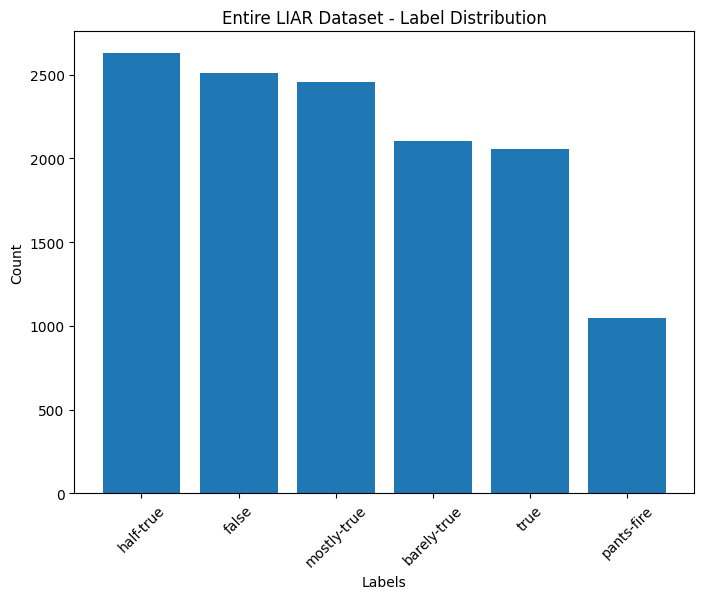

In [ ]:
train_path = "train.tsv"
valid_path = "valid.tsv"
test_path  = "test.tsv"

train_df, valid_df, test_df = load_liar_dataset(train_path, valid_path, test_path)

# Combine them to show overall distribution in entire dataset
full_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)
# Show 6-class distribution in entire dataset
show_label_distribution(full_df, label_col="label", dataset_name="Entire LIAR Dataset")

In [ ]:
# Preprocess statements
train_df["statement"] = train_df["statement"].apply(lambda x: advanced_preprocess(x))
valid_df["statement"] = valid_df["statement"].apply(lambda x: advanced_preprocess(x))
test_df["statement"]  = test_df["statement"].apply(lambda x: advanced_preprocess(x))

In [ ]:
le = LabelEncoder()
le.fit(train_df["label"].unique())

train_df["label_encoded"] = le.transform(train_df["label"])
valid_df["label_encoded"] = le.transform(valid_df["label"])
test_df["label_encoded"]  = le.transform(test_df["label"])

X_train_texts = train_df["statement"].values
y_train       = train_df["label_encoded"].values

X_valid_texts = valid_df["statement"].values
y_valid       = valid_df["label_encoded"].values

X_test_texts  = test_df["statement"].values
y_test        = test_df["label_encoded"].values

In [ ]:
print("\nConverting training texts to GloVe embeddings...")
X_train_glove = np.array([text_to_glove_vector(txt) for txt in X_train_texts])

print("Converting validation texts to GloVe embeddings...")
X_valid_glove = np.array([text_to_glove_vector(txt) for txt in X_valid_texts])

print("Converting test texts to GloVe embeddings...")
X_test_glove  = np.array([text_to_glove_vector(txt) for txt in X_test_texts])


Converting training texts to GloVe embeddings...
Converting validation texts to GloVe embeddings...
Converting test texts to GloVe embeddings...


# Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train_glove, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [ ]:
y_valid_pred = rf.predict(X_valid_glove)
print("\n=== Validation Set Performance ===")
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("\nClassification Report (Validation):")
print(classification_report(y_valid, y_valid_pred, target_names=le.classes_))


=== Validation Set Performance ===
Accuracy: 0.26791277258566976

Classification Report (Validation):
              precision    recall  f1-score   support

 barely-true       0.27      0.11      0.16       237
       false       0.28      0.46      0.35       263
   half-true       0.23      0.37      0.28       248
 mostly-true       0.28      0.33      0.31       251
  pants-fire       0.50      0.03      0.05       116
        true       0.35      0.11      0.17       169

    accuracy                           0.27      1284
   macro avg       0.32      0.23      0.22      1284
weighted avg       0.30      0.27      0.24      1284



In [ ]:
y_test_pred = rf.predict(X_test_glove)
print("\n=== Test Set Performance ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


=== Test Set Performance ===
Accuracy: 0.244672454617206

Classification Report (Test):
              precision    recall  f1-score   support

 barely-true       0.26      0.11      0.15       212
       false       0.24      0.39      0.29       249
   half-true       0.24      0.38      0.29       265
 mostly-true       0.25      0.30      0.27       241
  pants-fire       0.50      0.03      0.06        92
        true       0.25      0.08      0.12       208

    accuracy                           0.24      1267
   macro avg       0.29      0.21      0.20      1267
weighted avg       0.27      0.24      0.22      1267



# CNN

In [ ]:
#Reshape data for CNN input
X_train_glove = X_train_glove.reshape((X_train_glove.shape[0], X_train_glove.shape[1], 1))
X_valid_glove = X_valid_glove.reshape((X_valid_glove.shape[0], X_valid_glove.shape[1], 1))
X_test_glove  = X_test_glove.reshape((X_test_glove.shape[0], X_test_glove.shape[1], 1))


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# CNN Model
model = keras.Sequential([
    layers.Conv1D(128, 3, activation='relu', input_shape=(X_train_glove.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_glove, y_train, epochs=10, validation_data=(X_valid_glove, y_valid))

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5430 - loss: 1.1907 - val_accuracy: 0.2305 - val_loss: 2.1333
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5553 - loss: 1.1475 - val_accuracy: 0.2220 - val_loss: 2.2365
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5720 - loss: 1.1226 - val_accuracy: 0.2329 - val_loss: 2.3183
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5708 - loss: 1.0998 - val_accuracy: 0.2375 - val_loss: 2.3107
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5843 - loss: 1.0839 - val_accuracy: 0.2383 - val_loss: 2.3834
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.5987 - loss: 1.0514 - val_accuracy: 0.2336 - val_loss: 2.3686
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.6052 - loss: 1.0292 - val_accuracy: 0.2329 - val_loss: 2.4692
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.6038 - loss: 1.0309 - 

In [ ]:
y_valid_pred = np.argmax(model.predict(X_valid_glove), axis=1)
print("\n=== Validation Set Performance (CNN) ===")
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("\nClassification Report (Validation - CNN):")
print(classification_report(y_valid, y_valid_pred, target_names=le.classes_))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== Validation Set Performance (CNN) ===
Accuracy: 0.24065420560747663

Classification Report (Validation - CNN):
              precision    recall  f1-score   support

 barely-true       0.22      0.19      0.20       237
       false       0.24      0.22      0.23       263
   half-true       0.24      0.26      0.25       248
 mostly-true       0.25      0.27      0.26       251
  pants-fire       0.24      0.20      0.22       116
        true       0.26      0.30      0.27       169

    accuracy                           0.24      1284
   macro avg       0.24      0.24      0.24      1284
weighted avg       0.24      0.24      0.24      1284



In [ ]:
y_test_pred = np.argmax(model.predict(X_test_glove), axis=1)
print("\n=== Test Set Performance (CNN) ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test - CNN):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

=== Test Set Performance (CNN) ===
Accuracy: 0.24072612470402527

Classification Report (Test - CNN):
              precision    recall  f1-score   support

 barely-true       0.20      0.20      0.20       212
       false       0.27      0.24      0.26       249
   half-true       0.25      0.24      0.24       265
 mostly-true       0.27      0.32      0.29       241
  pants-fire       0.17      0.15      0.16        92
        true       0.23      0.22      0.23       208

    accuracy                           0.24      1267
   macro avg       0.23      0.23      0.23      1267
weighted avg       0.24      0.24      0.24      1267



# LSTM

In [ ]:
# LSTM Model
model = keras.Sequential([
    layers.LSTM(128, return_sequences=False, input_shape=(X_train_glove.shape[1], 1)),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_glove, y_train, epochs=10, validation_data=(X_valid_glove, y_valid))

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 108s 335ms/step - accuracy: 0.2306 - loss: 1.7313 - val_accuracy: 0.2368 - val_loss: 1.7435
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 108s 337ms/step - accuracy: 0.2287 - loss: 1.7224 - val_accuracy: 0.2399 - val_loss: 1.7424
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 140s 330ms/step - accuracy: 0.2320 - loss: 1.7282 - val_accuracy: 0.2430 - val_loss: 1.7399
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 145s 338ms/step - accuracy: 0.2343 - loss: 1.7225 - val_accuracy: 0.2399 - val_loss: 1.7406
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 143s 340ms/step - accuracy: 0.2384 - loss: 1.7228 - val_accuracy: 0.2453 - val_loss: 1.7397
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 105s 329ms/step - accuracy: 0.2351 - loss: 1.7225 - val_accuracy: 0.2414 - val_loss: 1.7375
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 144s 335ms/step - accuracy: 0.2502 - loss: 1.7192 - val_accuracy: 0.2445 - val_loss: 1.7375
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 144s 343ms/step - accuracy: 0.2434 -

In [ ]:
y_valid_pred = np.argmax(model.predict(X_valid_glove), axis=1)
print("\n=== Validation Set Performance (LSTM) ===")
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("\nClassification Report (Validation - LSTM):")
print(classification_report(y_valid, y_valid_pred, target_names=le.classes_))

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step

=== Validation Set Performance (LSTM) ===
Accuracy: 0.2250778816199377

Classification Report (Validation - LSTM):
              precision    recall  f1-score   support

 barely-true       0.00      0.00      0.00       237
       false       0.27      0.23      0.25       263
   half-true       0.20      0.41      0.27       248
 mostly-true       0.23      0.50      0.32       251
  pants-fire       0.00      0.00      0.00       116
        true       0.11      0.01      0.01       169

    accuracy                           0.23      1284
   macro avg       0.14      0.19      0.14      1284
weighted avg       0.15      0.23      0.17      1284



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_test_pred = np.argmax(model.predict(X_test_glove), axis=1)
print("\n=== Test Set Performance (LSTM) ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test - LSTM):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step

=== Test Set Performance (LSTM) ===
Accuracy: 0.2202052091554854

Classification Report (Test - LSTM):
              precision    recall  f1-score   support

 barely-true       0.00      0.00      0.00       212
       false       0.20      0.18      0.19       249
   half-true       0.22      0.42      0.29       265
 mostly-true       0.23      0.51      0.31       241
  pants-fire       0.00      0.00      0.00        92
        true       0.12      0.01      0.02       208

    accuracy                           0.22      1267
   macro avg       0.13      0.19      0.14      1267
weighted avg       0.15      0.22      0.16      1267



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
